### 패키지 준비하기

In [1]:
import sys
sys.path.append('../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.unicode_minus"] = False

### 데이터셋 준비하기

In [4]:
origin = read_excel("../Excel Data/서울시 주행실적 통계현황_1차수정.xlsx")
origin

,기록 일,대상년도,관리 자치구,관리 행정동,주행 실적 수,주행 거리,온실가스,마일리지,대당 연평균 감축
0,2021-07-20,2021,광진구,85000,1,1473,349,30000,NaN
1,2021-07-15,2021,동대문구,N,1,6732,1595,70000,NaN
2,2021-07-14,2021,강동구,54000,1,1299,308,30000,NaN
3,2021-07-14,2021,송파구,69000,1,3896,923,70000,NaN
4,2021-07-14,2021,송파구,67000,1,1954,463,50000,NaN
...,...,...,...,...,...,...,...,...,...
14407,2018-06-20,2018,종로구,57000,23,125752,29591,1452900,NaN
14408,2018-06-20,2018,종로구,56000,20,154697,35981,1190000,NaN
14409,2018-06-20,2018,종로구,55000,14,68258,16196,820000,NaN
14410,2018-06-20,2018,종로구,54000,3,10973,2539,210000,NaN


In [5]:
# 결측치 확인
origin.isna().sum()

기록 일             0
대상년도             0
관리 자치구           0
관리 행정동           0
주행 실적 수          0
주행 거리            0
온실가스             0
마일리지             0
대당 연평균 감축    14412
dtype: int64

In [6]:
# 기초통계량 확인
origin.describe()

,기록 일,대상년도,주행 실적 수,주행 거리,온실가스,마일리지,대당 연평균 감축
count,14412,14412.000000,14412.000000,1.441200e+04,14412.000000,1.441200e+04,0.0
mean,2020-07-28 22:34:46.261448960,2020.086664,8.743547,3.920099e+04,8942.829309,5.256993e+05,NaN
min,2018-06-20 00:00:00,2018.000000,1.000000,0.000000e+00,0.000000,1.000000e+04,NaN
25%,2020-01-02 00:00:00,2019.000000,1.000000,5.581750e+03,1251.750000,7.000000e+04,NaN
50%,2020-11-04 00:00:00,2020.000000,3.000000,1.360100e+04,3069.000000,1.700000e+05,NaN
75%,2021-05-10 00:00:00,2021.000000,8.000000,3.708700e+04,8426.250000,4.744700e+05,NaN
max,2021-07-20 00:00:00,2021.000000,604.000000,2.711147e+06,626079.000000,3.733965e+07,NaN
std,NaN,0.985382,18.409075,8.145699e+04,18732.785031,1.114703e+06,NaN


> 평균값의 차이가 크기 때문에 표준화가 필요해 보인다.

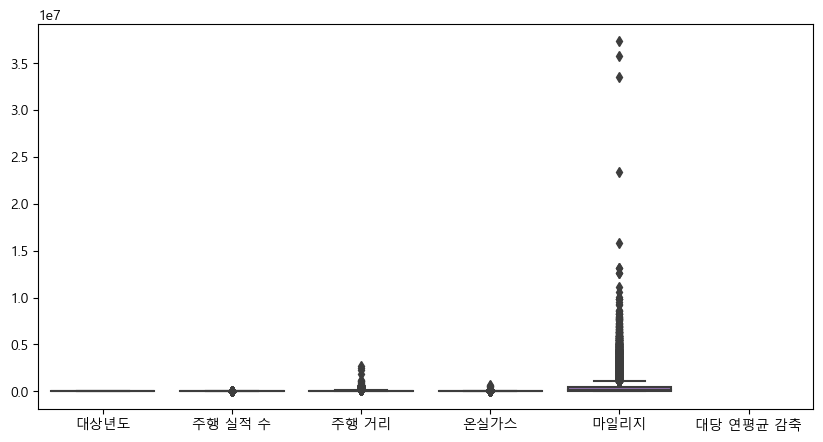

In [7]:
# boxplot으로 시각화
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()

c:\Users\kiman\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

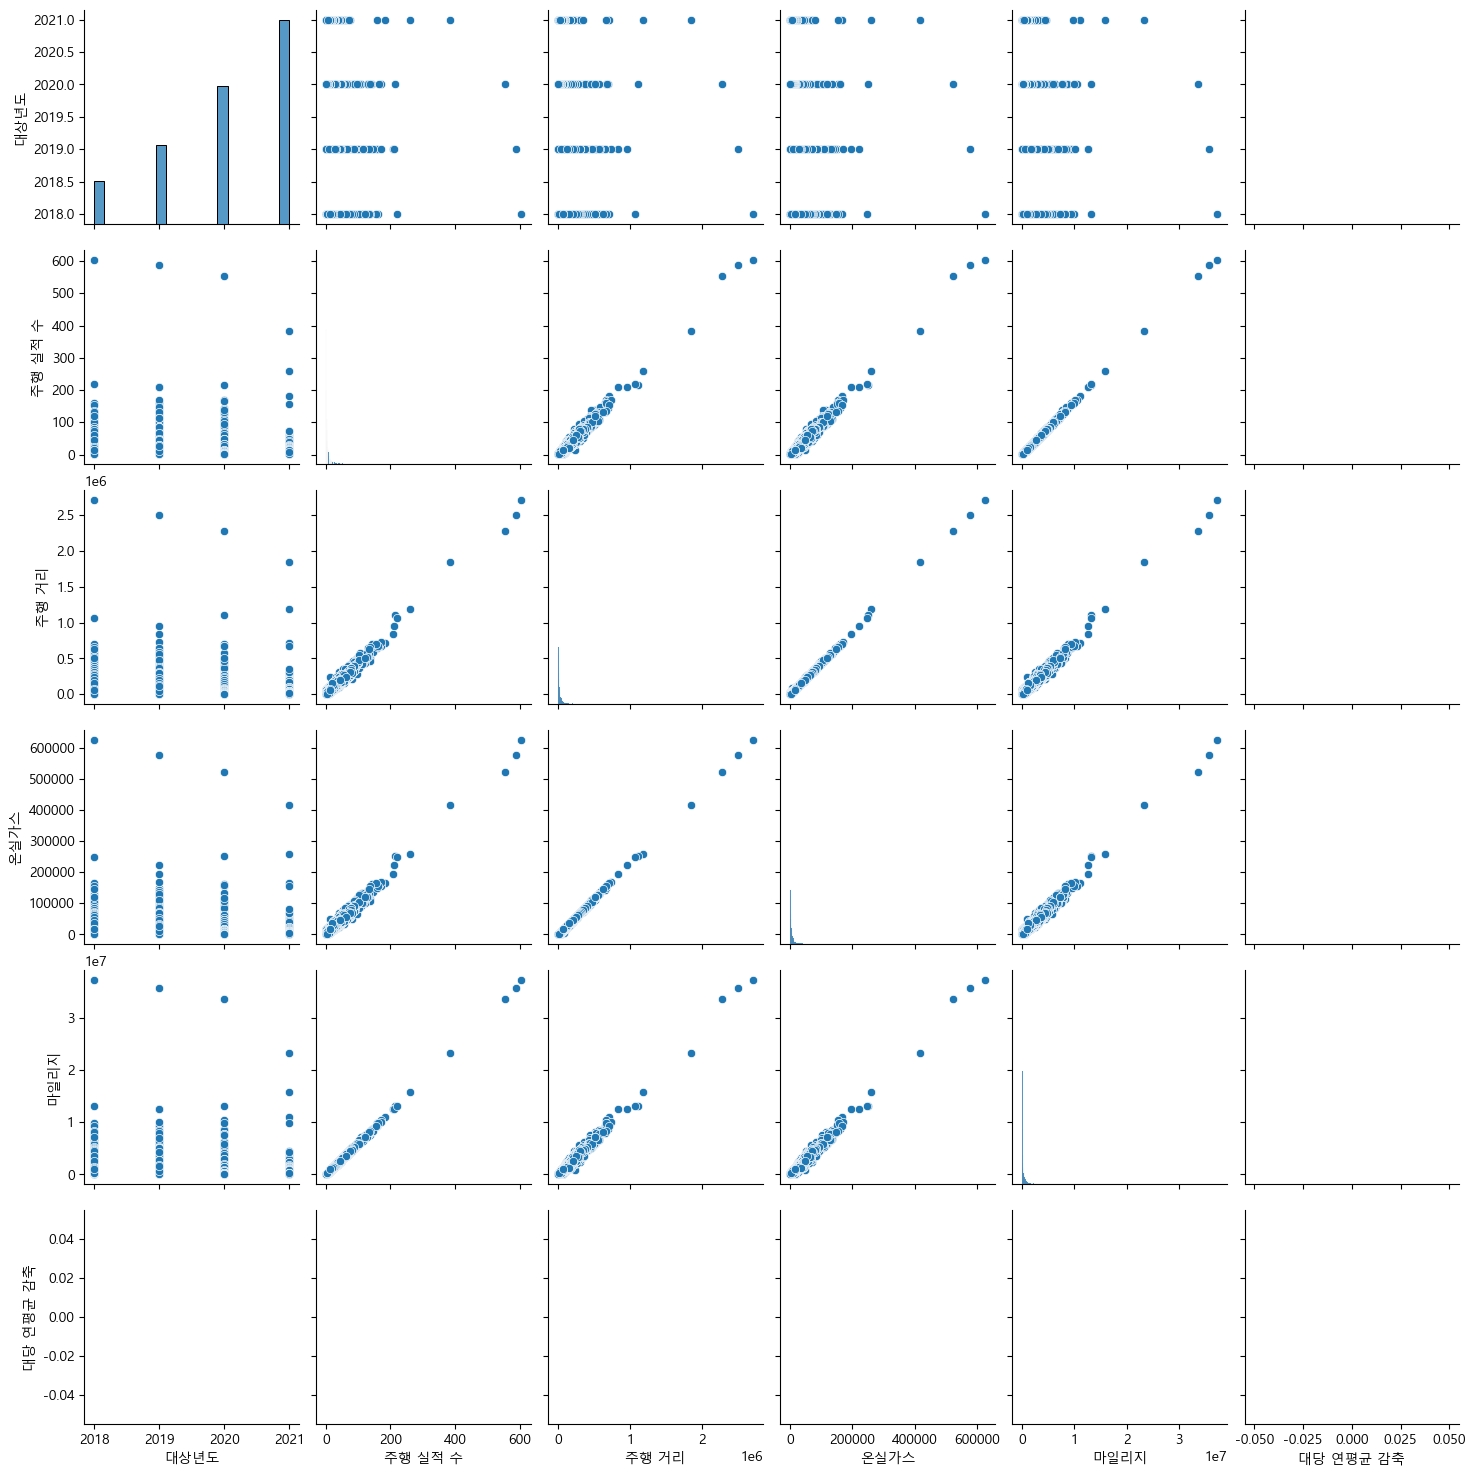

In [8]:
# 산점도 행렬로 시각화
plt.figure(figsize=(30, 30))
sb.pairplot(origin)
plt.show()
plt.close()

In [9]:
# 랜덤시드 고정
np.random.seed(777)

In [10]:
origin.columns

Index(['기록 일', '대상년도', '관리 자치구', '관리 행정동', '주행 실적 수', '주행 거리', '온실가스', '마일리지',
       '대당 연평균 감축'],
      dtype='object')

In [11]:
# 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기
x = origin[['주행 실적 수', '주행 거리', '온실가스']]
y = origin[['마일리지']]
x.shape, y.shape

((14412, 3), (14412, 1))

In [12]:
# 데이터 표준화
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)

y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)

x_scale.shape, y_scale.shape

((14412, 3), (14412, 1))

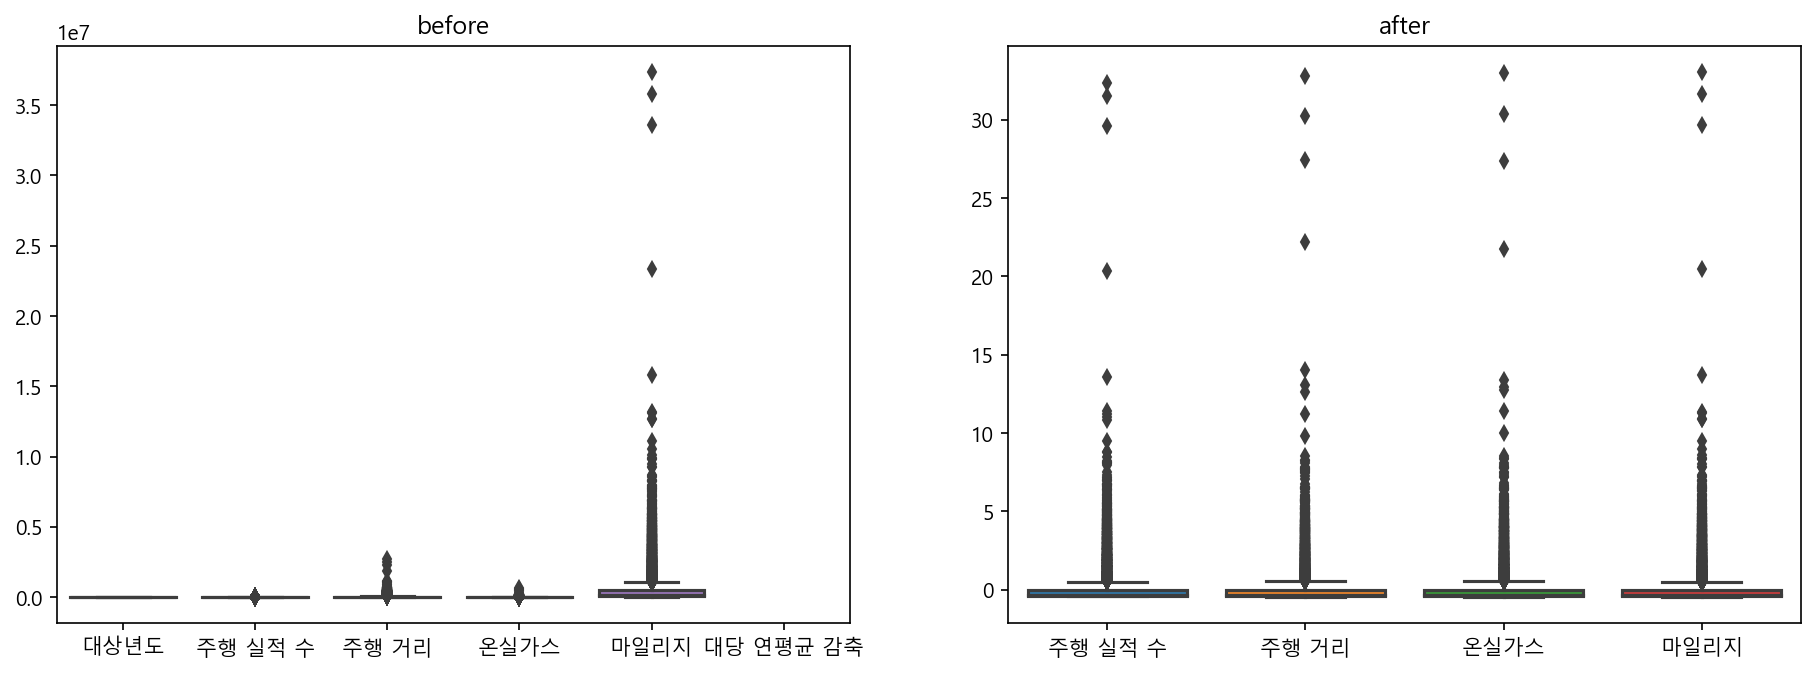

In [13]:
# 표준화 전 후 상자그림 비교

# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns=['주행 실적 수', '주행 거리', '온실가스'])
y_scale_df = DataFrame(y_scale, columns=['마일리지'])
tmp = merge(x_scale_df, y_scale_df, left_index=True, right_index=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=tmp, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련 데이터와 검증 데이터로 분할

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10088, 3), (4324, 3), (10088, 1), (4324, 1))

### 모델 개발

#### 모델 정의

데이터가 단순하고 개수가 적다면 과대적합이 발생할 확률이 높기 때문에 주의하면서 적절한 크기의 모델층을 쌓아야 한다.

In [15]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [18]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
316/316 [==============================] - 1s 2ms/step - loss: 0.0503 - mae: 0.0595 - val_loss: 0.0070 - val_mae: 0.0368 - lr: 0.0010
Epoch 2/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0035 - mae: 0.0301 - val_loss: 0.0017 - val_mae: 0.0247 - lr: 0.0010
Epoch 3/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0262 - val_loss: 0.0017 - val_mae: 0.0246 - lr: 0.0010
Epoch 4/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0031 - mae: 0.0288 - val_loss: 0.0016 - val_mae: 0.0248 - lr: 0.0010
Epoch 5/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0022 - mae: 0.0267 - val_loss: 0.0015 - val_mae: 0.0241 - lr: 0.0010
Epoch 6/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0082 - mae: 0.0318 - val_loss: 0.0229 - val_mae: 0.0615 - lr: 0.0010
Epoch 7/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0073 - mae: 0.0338 - val_loss: 0.0017 - val_mae

### 학습 결과 평가

In [19]:
# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.050292,0.059536,0.006966,0.036804,0.001
2,0.003504,0.030117,0.001693,0.024671,0.001
3,0.002015,0.026228,0.001672,0.024572,0.001
4,0.003132,0.028778,0.001561,0.024770,0.001
5,0.002187,0.026662,0.001497,0.024053,0.001
6,0.008175,0.031844,0.022924,0.061547,0.001
7,0.007259,0.033845,0.001663,0.024401,0.001
8,0.002226,0.026808,0.001446,0.023424,0.001
9,0.002223,0.026395,0.001685,0.025519,0.001


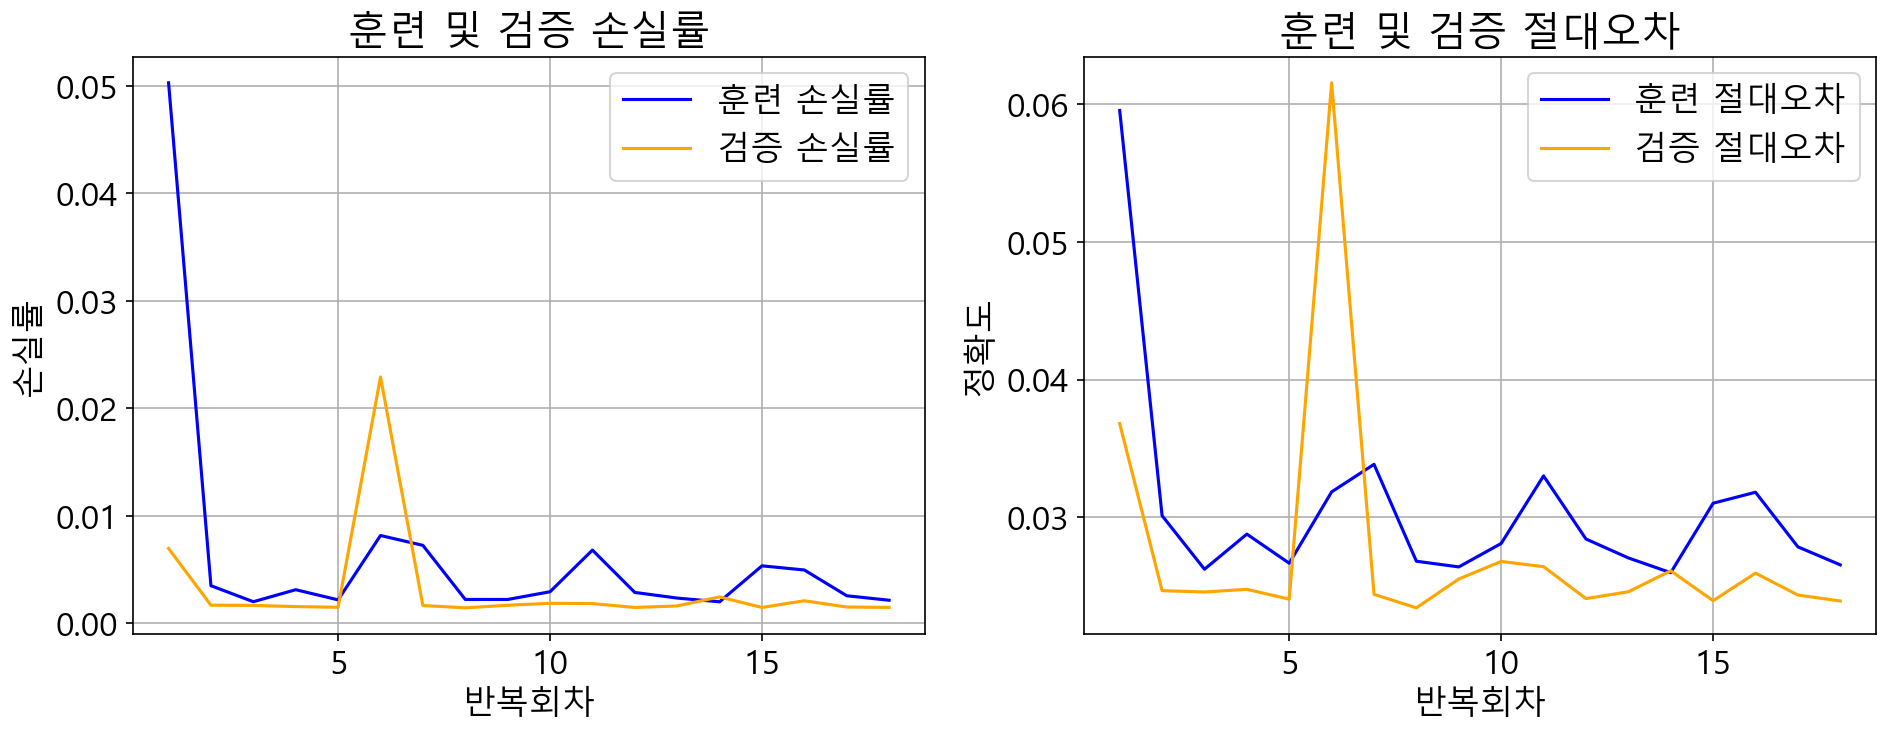

In [20]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [22]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

316/316 [==============================] - 0s 709us/step - loss: 0.0018 - mae: 0.0251
최종 훈련 손실률: 0.001800, 최종 훈련 절대오차: 0.025141
136/136 [==============================] - 0s 732us/step - loss: 0.0015 - mae: 0.0239
최종 검증 손실률: 0.001486, 최종 검증 절대오차: 0.023918


### 학습 결과 적용

#### 예측 결과 산정

In [23]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

136/136 [==============================] - 0s 719us/step


### 결과 데이터 셋 구성

In [24]:
train_df = DataFrame(x_train, columns=['주행 실적 수', '주행 거리', '온실가스'])
train_df['마일리지(관측치)'] = y_train.flatten()
train_df['마일리지(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['마일리지(관측치)']-train_df['마일리지(예측치)']

train_df.head()

,주행 실적 수,주행 거리,온실가스,마일리지(관측치),마일리지(예측치),훈련오차
0,-0.312006,-0.375659,-0.372719,-0.301166,-0.322345,0.021178
1,-0.420652,-0.422692,-0.417028,-0.408822,-0.413244,0.004422
2,-0.366329,-0.348368,-0.344372,-0.346023,-0.350163,0.004140
3,-0.312006,-0.072458,-0.049051,-0.283224,-0.279898,-0.003326
4,-0.420652,-0.463647,-0.459255,-0.444707,-0.431710,-0.012997


In [25]:
test_df = DataFrame(x_test, columns=['주행 실적 수', '주행 거리', '온실가스'])
test_df['마일리지(관측치)'] = y_test.flatten()
test_df['마일리지(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['마일리지(관측치)']-test_df['마일리지(예측치)']

test_df.head()

,주행 실적 수,주행 거리,온실가스,마일리지(관측치),마일리지(예측치),훈련오차
0,-0.420652,-0.444593,-0.437848,-0.408822,-0.422955,0.014133
1,-0.420652,-0.338055,-0.329798,-0.408822,-0.399826,-0.008996
2,0.720129,0.689787,0.703826,0.813357,0.736330,0.077027
3,-0.366329,-0.314520,-0.316346,-0.346023,-0.346372,0.000350
4,-0.257683,-0.215974,-0.212940,-0.238367,-0.236769,-0.001598


### 실제 결과값과 머신러닝에 의한 예측값 비교

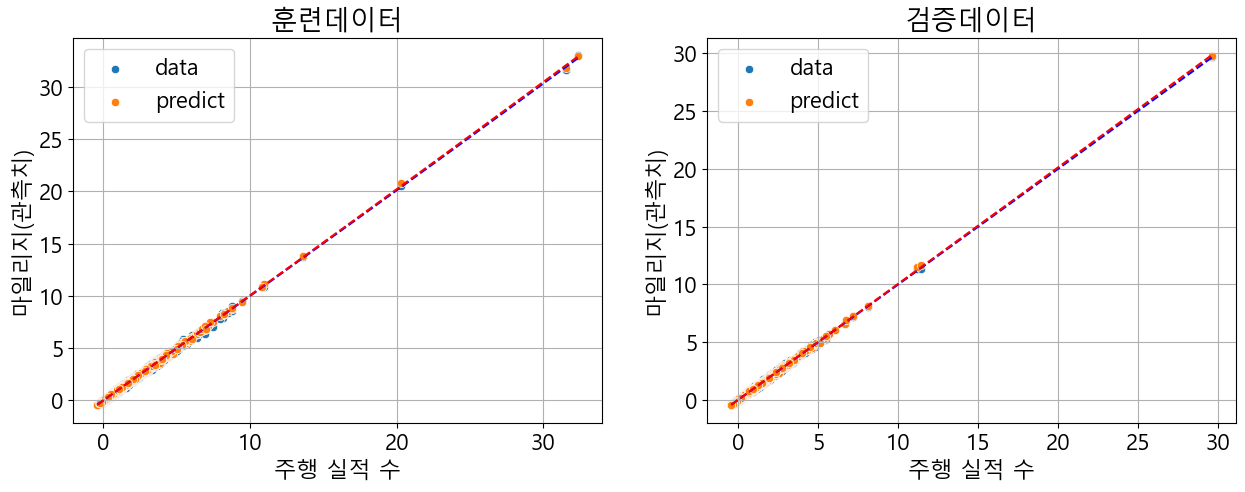

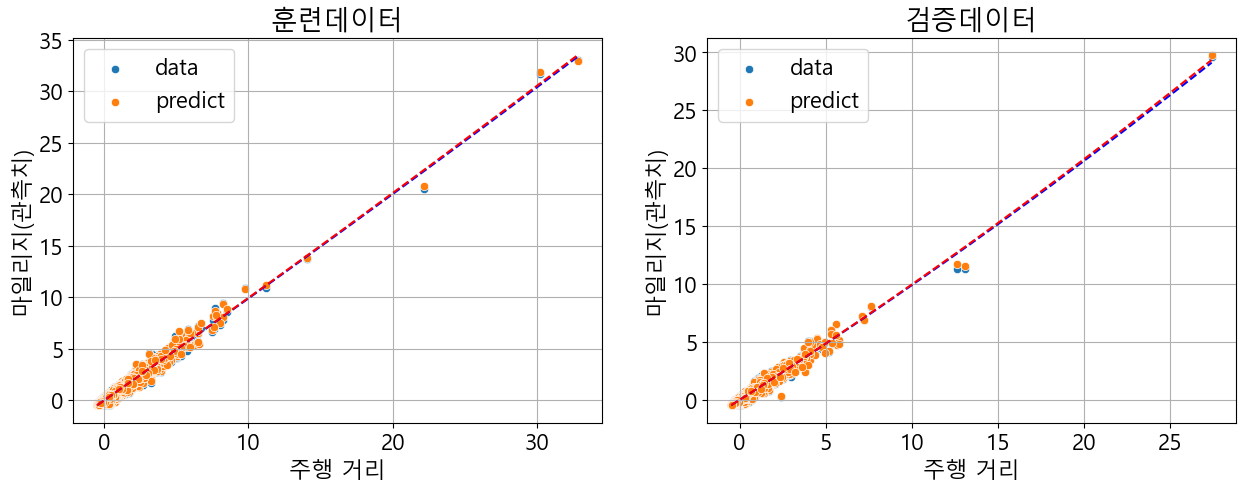

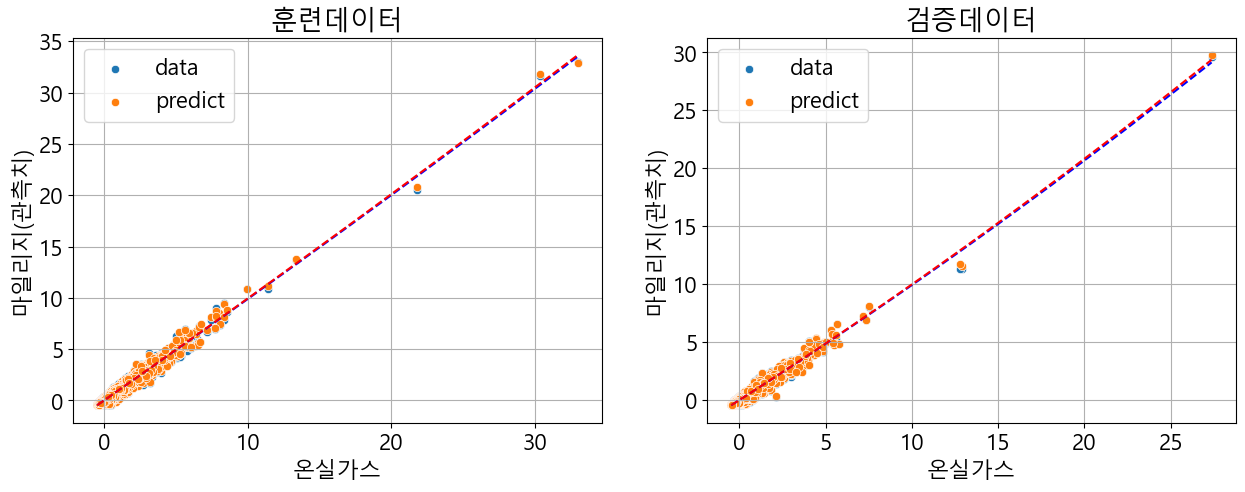

In [26]:
for key in ['주행 실적 수', '주행 거리', '온실가스']:
    helper.regplot(train_df[key], train_df['마일리지(관측치)'], train_df['마일리지(예측치)'], "훈련데이터",
                   test_df[key], test_df['마일리지(관측치)'], test_df['마일리지(예측치)'], "검증데이터",
                   figsize=(15, 5))